In [1]:
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import xarray as xr
import glob
import warnings
import matplotlib
import cartopy as cart
import cartopy.crs as ccrs
#import heatcarbontools as hct
import nc_time_axis
from cmip6_preprocessing.preprocessing import combined_preprocessing
#import pickle
import cftime
from datetime import datetime
xr.set_options(display_style='html')
plt.rcParams['figure.figsize'] = 5,2.5

import gsw as gs
from IPython.display import clear_output
import matplotlib.ticker as tick
import xskillscore as xs
from xgcm import Grid
from matplotlib.pyplot import cm
import seaborn as sns
import scipy.stats as stats

In [2]:
def corr_model(arr1, arr2):
    models = np.intersect1d(arr1.model.values,arr2.model.values)
    corr_co = xs.pearson_r(arr1.sel(model = models),arr2.sel(model = models),dim='model',skipna=True )
    corr_p = xs.pearson_r_p_value(arr1.sel(model = models),arr2.sel(model = models),dim='model',skipna=True )
    return corr_co, corr_p, models

def scatter_mods(arr1,arr2,legfont,markersize):
    fig, ax = plt.subplots(figsize =(6, 6))
    mm = np.intersect1d(arr1.model.values,arr2.model.values)
    arr1= arr1.sel(model=mm)
    arr2=arr2.sel(model=mm)
    doa = xr.merge([arr1.rename('var1'),arr2.rename('var2')])
    #print(mm)
    doa.plot.scatter(x='var1',y='var2',hue='model', cmap='Greens',s=markersize)
    #ax.scatter(arr1,arr2,c=arr1,cmap='Greens',s=200)
    
    x = arr1
    y=arr2
    rrr = xr.corr(x,y)
    #m, b = np.polyfit(x, y, 1)
    #plt.plot(x, m*x+b,color='b') 
    #plt.plot([0,1],[1,0], transform=ax.transAxes,color='lightblue')
    plt.title('Correlation R = '+str(np.round(rrr.values,2)))
    ax.legend(mm,ncol=2,fontsize=legfont)
    return


def get_region_mean(arr,basins):
    globe = arr.mean('x').assign_coords(region='globe')
    #pac = arr.where((basins ==3) | (basins ==1)).mean('x').assign_coords(region='pac')
    atl = arr.where((basins ==2) | (basins ==1)).mean('x').assign_coords(region='atl')
    #ind= arr.where((basins ==5) | (basins ==1)).mean('x').assign_coords(region='ind')
    ip= arr.where((basins ==5) | (basins ==1)| (basins == 3)).mean('x').assign_coords(region='ip')
    #wpac = arr.where((basins ==3) | (basins ==1)).sel(x= slice(125,175)).mean('x').assign_coords(region='wpac')
    #arr2 = xr.concat([globe,pac,atl,ind,ip,wpac],dim='region')
    arr2 = xr.concat([globe,atl,ip],dim='region')
    return arr2


def get_region_sum(arr,dx,basins):
    arr = arr*dx
    globe = arr.sum('x').assign_coords(region='globe')
    pac = arr.where((basins ==3) | (basins ==1)).sum('x').assign_coords(region='pac')
    atl = arr.where((basins ==2) | (basins ==1)).sum('x').assign_coords(region='atl')
    ind= arr.where((basins ==5) | (basins ==1)).sum('x').assign_coords(region='ind')
    ip= arr.where((basins ==5) | (basins ==1)| (basins == 3)).sum('x').assign_coords(region='ip')
    arr2 = xr.concat([globe,pac,atl,ind,ip],dim='region')
    return arr2


In [3]:
file_dx = '/gws/nopw/j04/ukfafmip/users/enewsom/regrid_from_jonathan_thetoa/cmip5/dx_regrid.nc'
da =  xr.open_dataset(file_dx).assign_attrs(source_id='model')
da=combined_preprocessing(da)
dx = da['dx']

file_dx = '/gws/nopw/j04/ukfafmip/users/enewsom/regrid_from_jonathan_thetoa/cmip5/area_regrid.nc'
da =  xr.open_dataset(file_dx).assign_attrs(source_id='model')
da=combined_preprocessing(da)
area = da['cell_area']

dy= area/dx

file_basin = '/gws/nopw/j04/ukfafmip/users/enewsom/regrid_from_jonathan_thetoa/basin_regridded.nc'
da =  xr.open_dataset(file_basin).assign_attrs(source_id='model')
da=combined_preprocessing(da)
basins = da['basin']
basins = basins.where(basins>0,drop='true')

basins2 = basins
basins2[0:50,25:140,]=5
basins2[0:50,140:290]=3
basins2[0:50,290:361]=2
basins2[0:50,0:25]=2

basins = da['basin']
basins = basins.where(basins>0,drop='true')
basins2=basins2.where(basins>0,drop='true')

file_dx = '/gws/nopw/j04/ukfafmip/users/enewsom/regrid_from_jonathan_thetoa/cmip5/dx_regrid.nc'
da =  xr.open_dataset(file_dx).assign_attrs(source_id='model')
da=combined_preprocessing(da)
dx = da['dx']

file_dx = '/gws/nopw/j04/ukfafmip/users/enewsom/regrid_from_jonathan_thetoa/cmip5/area_regrid.nc'
da =  xr.open_dataset(file_dx).assign_attrs(source_id='model')
da=combined_preprocessing(da)
area = da['cell_area']

In [12]:

SST_change_cmip5 =  xr.open_dataarray('SST_change_cmip5.nc').rename('sst_anom')
SST_change_cmip6 =  xr.open_dataarray('SST_change_cmip6.nc').rename('sst_anom')
OHU_change_cmip5 =  xr.open_dataarray('SST_change_cmip5.nc').rename('ohu_anom')
OHU_change_cmip6 =  xr.open_dataarray('SST_change_cmip6.nc').rename('ohu_anom')

SST_change = xr.concat([SST_change_cmip5,SST_change_cmip6],dim='model')
OHU_change = xr.concat([OHU_change_cmip5,OHU_change_cmip6],dim='model')



In [69]:
models_cmip5=SST_change_cmip5.model
models_cmip6=SST_change_cmip6.model

In [64]:
SST = (SST_change*area).sum(['x','y'])/((SST_change/SST_change*area).sum(['x','y']))
SST = (SST_change*area).sum(['x','y'])/((area).sum(['x','y']))*1.8


sohl_lats = slice(-90,-60)
nh_lats = slice(60,90)
ll_lats = slice(-30,30)
ml_lats = slice(-60,60)

OHU_change_gl = (OHU_change*area).sum(['x','y']).assign_coords(surf_reg='global') 
OHU_change_sohl = (OHU_change*area).sel(y=sohl_lats).sum(['x','y']).assign_coords(surf_reg='so_highlats') 
OHU_change_nh= (OHU_change*area).sel(y=nh_lats).sum(['x','y']).assign_coords(surf_reg='nh_highlats') 
OHUA  = (OHU_change*area)
OHU_change_ml = OHUA.sel(y=ml_lats).where(np.abs(OHUA.y)>30).sum(['x','y']).assign_coords(surf_reg='mid_lats')
OHU_change_ll = (OHU_change*area).sel(y=ll_lats).sum(['x','y']).assign_coords(surf_reg='low_lats') 

OHU = xr.concat([OHU_change_gl,OHU_change_nh,OHU_change_sohl,OHU_change_ml,OHU_change_ll],dim='surf_reg')
OHUE = OHU/SST/area.sum(['x','y']).rename('ohue')


In [19]:
strat_cmip5 = xr.open_dataarray('N2_cmip5.nc').mean('x')
strat_cmip6 = xr.open_dataarray('N2_cmip6.nc').mean('x')

density_cmip5 = xr.open_dataarray('density_cmip5.nc').mean('x')
density_cmip6 = xr.open_dataarray('density_cmip6.nc').mean('x')

drhody_cmip5 = xr.open_dataarray('drhody_cmip5.nc').mean('x')
drhody_cmip6 = xr.open_dataarray('drhody_cmip6.nc').mean('x')
drhodz_cmip5 = xr.open_dataarray('drhodz_cmip5.nc').mean('x')
drhodz_cmip6 = xr.open_dataarray('drhodz_cmip6.nc').mean('x')
slope_cmip5 = (drhodz_cmip5/drhody_cmip5).rename('isopycnal_slope')
slope_cmip6 = (drhodz_cmip6/drhody_cmip6).rename('isopycnal_slope')


strat = xr.concat([strat_cmip5,strat_cmip6],dim='model')
density = xr.concat([density_cmip5,density_cmip6],dim='model')
slope = xr.concat([slope_cmip5, slope_cmip6],dim='model')

In [27]:
lat = -40
lat = -45
#lat = -48
depth = 4500 #OG
lat = -45


rho_norm = -(density -density.max('lev'))
rho_norm = rho_norm.where(rho_norm<rho_norm.sel(lev=400,method='nearest').sel(y=lat,method='nearest'))
rho_norm = rho_norm/rho_norm.max('lev')




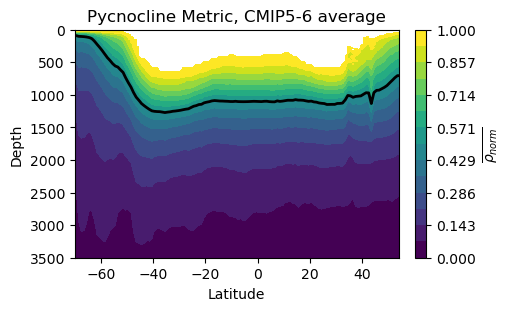

In [28]:
fig = plt.figure(figsize =(5, 3),constrained_layout=True)
rho_norm.mean('model').plot.contourf(levels=15,vmax=1,cbar_kwargs={'label': r'$\overline{\rho_{norm}}$'})
rho_norm.mean('model').plot.contour(levels=[.5],colors='k',linewidths=2)
plt.ylim(3500,0)
plt.title('Pycnocline Metric, CMIP5-6 average')
plt.ylabel('Depth')
plt.xlabel('Latitude')
plt.xlim(-70,54)
plt.savefig('Pyc_metric.pdf')


In [60]:
P = rho_norm.rename('variation')

Y=rho_norm.y.values
lev=rho_norm.lev.values
file_lev_bounds = '/gws/nopw/j04/ukfafmip/users/enewsom/regrid_from_jonathan_thetoa/cmip6/CONCATTED/thetao_Oyr_CESM2_piControl_r1i1p1f1_gn_regridded_050001-059912.nc'
dh  = xr.open_dataset(file_lev_bounds).assign_attrs(source_id='CESM2')
dh=combined_preprocessing(dh)
lev_bounds=dh.lev_bounds.isel(bnds=1).values



ds = xr.Dataset(
     coords={
         "y_c": (
             ["y_c"],
             Y,
                   ),
         "y_g": (
             ["y_g"],
             Y+.5, ),
     "lev": (
             ["lev"],
             lev,
         ),
         "lev_g": (
             ["lev_g"],
             lev_bounds)})
grid = Grid(ds, coords={"Y": {"center": "y_c", "right": "y_g"},"lev": {"center": "lev", "right": "lev_g"}},periodic=False)
grid
lev_grid = P.lev.broadcast_like(P)
target_levels = np.arange(0,1,.025)
depth_rho_norm = grid.transform(lev_grid, 'lev', target_levels, target_data=rho_norm, method='linear')
depth_rho_norm=depth_rho_norm.rename('rho_norm')

/home/users/enewsom/.conda/envs/nbenv2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


In [79]:
falloff=.63
lats = slice(-60,30)
#lat = -30
#mods =np.intersect1d(depth_all.model,OHU_all.model)
reg=3
region= 0

lev_slice2 = slice(400,700)
lat_slice2 = slice(-55,-45)

#used for now in figs
lev_slice = slice(450,700)
lat_slice = slice(-60,-48)


dz = xr.zeros_like(strat.isel(model=0))
dz0 = np.gradient(strat.lev.broadcast_like(strat.isel(model=0)))[0]
dz.values = dz0
dz_m = dz.sel(lev=lev_slice,y=lat_slice).sum(['lev','y'])


d = depth_rho_norm.sel(density=falloff,method='nearest').sel(y=lats).mean('y')
n = (strat*dz).sel(lev=lev_slice,y=lat_slice).sum(['lev','y'])*1e5/dz_m
s = (slope*dz).sel(lev=lev_slice2,y=lat_slice2).sum(['lev','y'])*1e3/dz_m
df = xr.merge([OHUE.dropna('model').rename('ohue'),d.rename('depth'),n.rename('N2'),s.rename('slope')])



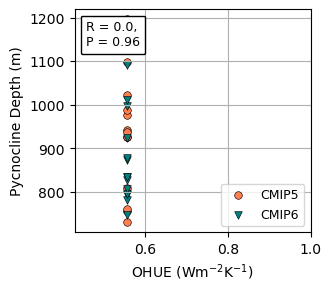

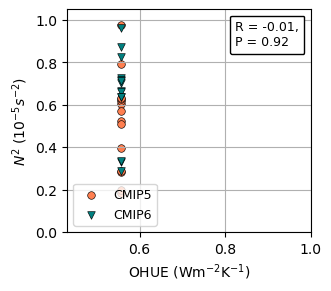

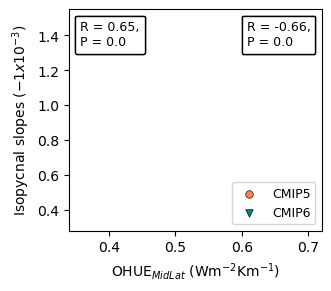

In [80]:
import seaborn as sns
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText


def textonly(ax, txt, fontsize = 14, loc = 2, *args, **kwargs):
    at = AnchoredText(txt,
                      prop=dict(size=fontsize), 
                      frameon=True,
                      loc=loc)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.1")
    ax.add_artist(at)
    return at

surfs = np.array([0,3])
metrics = ['depth','N2','slope']
for surf in surfs:
    for metric in metrics:


        if surf ==0:
            strt = 'global'
            fig, ax = plt.subplots(1,figsize =(3.2,2.8),constrained_layout=True)
        if surf ==1:
            strt = 'NH'
            fig, ax = plt.subplots(1,figsize =(3.2,2.8),constrained_layout=True)
        if surf ==2:
            strt = 'SH'
            fig, ax = plt.subplots(1,figsize =(3.2,2.8),constrained_layout=True)
        if surf ==4:
            strt = 'midlats'
            fig, ax = plt.subplots(1,figsize =(3.2,2.8),constrained_layout=True)
        if surf ==5:
            strt = 'LL'
            fig, ax = plt.subplots(1,figsize =(3.2,2.8),constrained_layout=True)
       
            
        data5 = df.isel(surf_reg=surf).sel(model=models_cmip5) 
        data6 = df.isel(surf_reg=surf).sel(model=models_cmip6)
        data_full = df.isel(surf_reg=surf)
        
        r5 = xr.corr(data5[metric],data5.ohue)
        r6 = xr.corr(data6[metric],data6.ohue)
        p = xs.pearson_r_p_value(data_full[metric],data_full.ohue,dim='model',skipna=True )
        r = xr.corr(data_full[metric],data_full.ohue)

        sns.scatterplot(data=data5, x="ohue", y=metric, edgecolor='k',  color="coral",s=30, marker='o')
        sns.scatterplot(data=data6, x="ohue", y=metric,edgecolor='k',  color="teal",s=30, marker='v')
        sns.regplot(x='ohue', y=metric, data=data_full, fit_reg=True,ci=0, ax=ax,scatter=False, color="k")
        if r.values <0:
            loc1 = 3
            loc2 =1
        else:
            loc1 = 4
            loc2 = 2
        plt.legend(['CMIP5','CMIP6'],fontsize=9,loc=loc1)
        at = textonly(plt.gca(), 'R = '+str(np.round(r.values,2))+',\nP = '+str(np.round(p.values,2)),fontsize=9,loc=loc2)
            
        if metric == 'N2':
            plt.ylabel('$N^2$ ($10^{-5}s^{-2}$)')
            plt.ylim(0.0, 1.05)
        if metric == 'slope':
            plt.ylabel('Isopycnal slopes ($-1x10^{-3}$)')
            
            plt.ylim(.28,1.55)
        if metric == 'depth':
            plt.ylabel('Pycnocline Depth (m)')
            #plt.ylim(870,2000)
        if surf == 3:
            plt.xlabel('OHUE$_{MidLat}$ (Wm$^{-2}$Km$^{-1}$)')
            plt.xlim(.34,.72)
        if surf == 0:
            plt.xlabel('OHUE (Wm$^{-2}$K$^{-1}$)')
            plt.xlim(.43,1)
        if surf == 1:
            plt.xlabel('OHUE$_{NHighLat}$ (Wm$^{-2}$K$^{-1}$)')
        if surf == 2:
            plt.xlabel('OHUE$_{SHighLat}$ (Wm$^{-2}$K$^{-1}$)')
        if surf == 4:
            plt.xlabel('OHUE$_{LowLat}$ (Wm$^{-2}$K$^{-1}$)')
        plt.grid()
        
        #plt.savefig('OHUE_metrics_plot_'+metric+'_'+strt+'.pdf')